In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import lr_scheduler

import torchvision
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms

import random as rand
from random import *
import os
import cv2
import copy
import time
from PIL import Image

# 첫 번째 시도(No Normalize & No Augmentation)
### 데이터셋 정의 및 transforms

In [28]:
train_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [31]:
data_dir = "../Data_Set/Labeld_Crop_Data/"
trDsets = {x: dset.ImageFolder(os.path.join(data_dir, x), train_transforms[x]) for x in ['train', 'val']}
trLoaders = {x: torch.utils.data.DataLoader(trDsets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}

teDsets = dset.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)
teLoaders = torch.utils.data.DataLoader(teDsets, batch_size=64, shuffle=False, num_workers=4)

In [117]:
print(trDsets['train'].classes)
print(teDsets.classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']


여기서 틀린 부분을 알아챔..ㅠ  
train class가 0, 1, 10 으로 시작하기 때문에, 이전에 만들어놨던 answer csv의 경우도 이 순서대로 했어야 했음..

In [118]:
trDsets_sizes = {x: len(trDsets[x]) for x in ['train', 'val']}
class_names = trDsets['train'].classes

### GPU 사용

In [125]:
print(torch.cuda.is_available())     # GPU 사용 가능 여부
print(torch.cuda.current_device())   # GPU 디바이스의 위치
print(torch.cuda.device_count())     # 사용가능한 GPU 개수
print(torch.cuda.get_device_name(0)) # GPU의 이름
print(torch.cuda.device(0))

True
0
1
GeForce RTX 2070


In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

### 모델 생성 - ResNet18

In [37]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=11)

### 모델 훈련

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    
    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=11, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
                if epoch > 0:
                    scheduler.step(val_loss)
                    
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in trLoaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / trDsets_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / trDsets_sizes['val']
            epoch_acc = running_corrects.double() / trDsets_sizes[phase]

            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
torch.cuda.empty_cache()
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.0320 Acc: 0.4170
val Loss: 1.1507 Acc: 0.6704
Current learning rate : 0.00100000
Validation loss decreased (inf --> 1.150731).  Saving model ...
Epoch 1/99
----------
train Loss: 0.8641 Acc: 0.7676
val Loss: 0.6431 Acc: 0.8122
Current learning rate : 0.00100000
Validation loss decreased (1.150731 --> 0.643102).  Saving model ...
Epoch 2/99
----------
train Loss: 0.4835 Acc: 0.8790
val Loss: 0.7171 Acc: 0.7811
Current learning rate : 0.00100000
EarlyStopping counter: 1 out of 11
Epoch 3/99
----------
train Loss: 0.3309 Acc: 0.9134
val Loss: 0.4610 Acc: 0.8570
Current learning rate : 0.00100000
Validation loss decreased (0.643102 --> 0.460997).  Saving model ...
Epoch 4/99
----------
train Loss: 0.2447 Acc: 0.9314
val Loss: 0.3748 Acc: 0.8761
Current learning rate : 0.00100000
Validation loss decreased (0.460997 --> 0.374755).  Saving model ...
Epoch 5/99
----------
train Loss: 0.1904 Acc: 0.9466
val Loss: 0.3388 Acc: 0.8977
Current learning rate : 0.0

In [44]:
torch.save(model_ft, 'lotte_model_resnet18_v2.pt')

### 모델 테스트

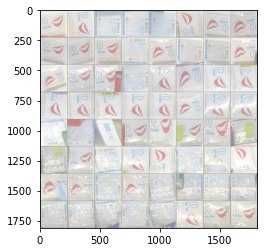

GroundTruth:      0     0     0     0


In [56]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

teDiter = iter(teLoaders)
images, labels = teDiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [82]:
testModel = torch.load('lotte_model_resnet18_v2.pt', map_location=device)

#### 전체 테스트 결과

In [83]:
correct = 0
total = 0
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = testModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (100 * correct / total))

Accuracy of test images: 98 %


#### 클래스별 테스트 결과

In [119]:
tag_classes = ['ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 'vita500', 'welchs', 'zec']
tag_dict = dict()
for i, label in enumerate(tag_classes):
    tag_dict[i] = label

print(tag_dict)

{0: 'ID_gum', 1: 'buttering', 2: 'couque_coffee', 3: 'chocopie', 4: 'cidar', 5: 'couque_white', 6: 'coke', 7: 'diget_ori', 8: 'diget_choco', 9: 'gumi_gumi', 10: 'homerunball', 11: 'jjolbyung_noodle', 12: 'juicyfresh', 13: 'jjolbyung_ori', 14: 'spearmint', 15: 'squid_peanut', 16: 'samdasu', 17: 'tuna', 18: 'toreta', 19: 'vita500', 20: 'welchs', 21: 'zec'}


In [123]:
class_correct = list(0 for i in range(len(class_names)))
class_total = list(0 for i in range(len(class_names)))
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(c.size(0)):
            label = labels[i]
            class_correct[int(label.item())] += c[i].item()
            class_total[int(label.item())] += 1

for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (tag_dict[int(class_names[i])], 100 * class_correct[i] / class_total[i]))

Accuracy of ID_gum : 98 %
Accuracy of buttering : 100 %
Accuracy of homerunball : 100 %
Accuracy of jjolbyung_noodle : 100 %
Accuracy of juicyfresh : 100 %
Accuracy of jjolbyung_ori : 99 %
Accuracy of spearmint : 96 %
Accuracy of squid_peanut : 100 %
Accuracy of samdasu : 100 %
Accuracy of  tuna : 99 %
Accuracy of toreta : 99 %
Accuracy of vita500 : 100 %
Accuracy of couque_coffee : 99 %
Accuracy of welchs : 99 %
Accuracy of   zec : 99 %
Accuracy of chocopie : 99 %
Accuracy of cidar : 98 %
Accuracy of couque_white : 99 %
Accuracy of  coke : 98 %
Accuracy of diget_ori : 96 %
Accuracy of diget_choco : 93 %
Accuracy of gumi_gumi : 100 %


# 두 번째 시도(Normalize & No Augmentation)
### 데이터셋 정의 및 transforms

normalized 된 것과 안된 것을 비교해보자.

In [247]:
testPath = "../Data_Set/Resize_Crop_Data_2/"
testDir = dset.ImageFolder(os.path.join(testPath, 'train'))
numList = [i for i in range(len(testDir))]

In [248]:
def display_augmented_images(customTransform):
    fig, subplots = plt.subplots(2, 5, figsize=(13, 6))
    
    for i in range(5):
        axi1 = subplots.flat[i]
        axi2 = subplots.flat[i+5]

        ori_img = testDir[randSample[i]][0]
        trf_img = customTransform(ori_img)

        axi1.imshow(ori_img)
        axi2.imshow(transforms.functional.to_pil_image(trf_img))
        axi1.set_title('original')
        axi2.set_title('transformed')

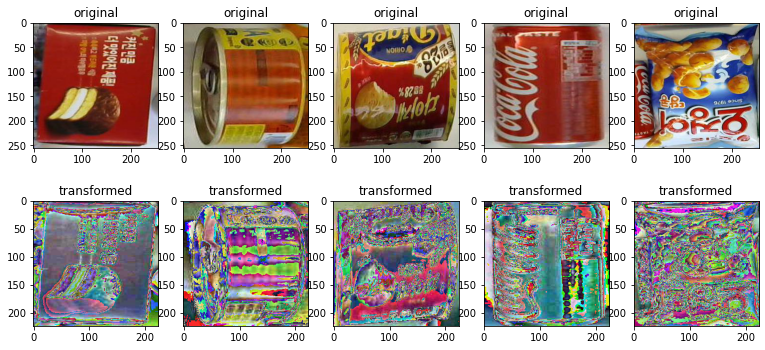

In [252]:
randSample = rand.sample(numList, 5)
norm1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
display_augmented_images(norm1)

In [231]:
train_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [232]:
data_dir = "../Data_Set/Labeld_Crop_Data/"
trDsets = {x: dset.ImageFolder(os.path.join(data_dir, x), train_transforms[x]) for x in ['train', 'val']}
trLoaders = {x: torch.utils.data.DataLoader(trDsets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}

teDsets = dset.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)
teLoaders = torch.utils.data.DataLoader(teDsets, batch_size=64, shuffle=False, num_workers=4)

In [233]:
trDsets_sizes = {x: len(trDsets[x]) for x in ['train', 'val']}
class_names = trDsets['train'].classes

### 모델 생성

In [234]:
device2 = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [235]:
model2 = models.resnet18(pretrained=False)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(class_names))
model2 = model2.to(device2)
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

위에서 학습할 때, patience가 10인 상태에서 더 좋은 결과를 냈기 때문에 조금 늘려주자.

In [236]:
criterion2 = nn.CrossEntropyLoss()
optimizer_ft2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, factor=0.1, patience=15)

### 모델 훈련

In [237]:
torch.cuda.empty_cache()
model_ft2 = train_model(model2, criterion2, optimizer_ft2, exp_lr_scheduler2, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.0525 Acc: 0.4229
val Loss: 1.1413 Acc: 0.6964
Current learning rate : 0.00100000
Validation loss decreased (inf --> 1.141265).  Saving model ...
Epoch 1/99
----------
train Loss: 0.8562 Acc: 0.7784
val Loss: 0.6320 Acc: 0.8286
Current learning rate : 0.00100000
Validation loss decreased (1.141265 --> 0.632022).  Saving model ...
Epoch 2/99
----------
train Loss: 0.5032 Acc: 0.8639
val Loss: 0.3490 Acc: 0.9133
Current learning rate : 0.00100000
Validation loss decreased (0.632022 --> 0.349005).  Saving model ...
Epoch 3/99
----------
train Loss: 0.3428 Acc: 0.9117
val Loss: 0.2800 Acc: 0.9305
Current learning rate : 0.00100000
Validation loss decreased (0.349005 --> 0.279971).  Saving model ...
Epoch 4/99
----------
train Loss: 0.2573 Acc: 0.9303
val Loss: 0.2325 Acc: 0.9301
Current learning rate : 0.00100000
Validation loss decreased (0.279971 --> 0.232533).  Saving model ...
Epoch 5/99
----------
train Loss: 0.2072 Acc: 0.9430
val Loss: 0.1929 Acc: 

val Loss: 0.0600 Acc: 0.9900
Current learning rate : 0.00100000
EarlyStopping counter: 5 out of 11
Epoch 50/99
----------
train Loss: 0.0156 Acc: 0.9954
val Loss: 0.0640 Acc: 0.9868
Current learning rate : 0.00100000
EarlyStopping counter: 6 out of 11
Epoch 51/99
----------
train Loss: 0.0298 Acc: 0.9921
val Loss: 0.0789 Acc: 0.9840
Current learning rate : 0.00100000
EarlyStopping counter: 7 out of 11
Epoch 52/99
----------
train Loss: 0.0374 Acc: 0.9911
val Loss: 0.0631 Acc: 0.9860
Current learning rate : 0.00100000
EarlyStopping counter: 8 out of 11
Epoch 53/99
----------
train Loss: 0.0192 Acc: 0.9949
val Loss: 0.1110 Acc: 0.9720
Current learning rate : 0.00100000
EarlyStopping counter: 9 out of 11
Epoch 54/99
----------
train Loss: 0.0474 Acc: 0.9866
val Loss: 0.0908 Acc: 0.9744
Current learning rate : 0.00100000
EarlyStopping counter: 10 out of 11
Epoch 55/99
----------
train Loss: 0.0258 Acc: 0.9921
val Loss: 0.0860 Acc: 0.9800
Current learning rate : 0.00100000
EarlyStopping cou

In [244]:
torch.save(model_ft2, 'lotte_model_resnet18_v3.pt')

### 모델 테스트

In [245]:
testModel2 = torch.load('lotte_model_resnet18_v3.pt', map_location=device2)

In [246]:
correct = 0
total = 0
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = testModel2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (100 * correct / total))

Accuracy of test images: 99 %


#### 클래스별 테스트

In [254]:
class_correct = list(0 for i in range(len(class_names)))
class_total = list(0 for i in range(len(class_names)))
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = model_ft2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(c.size(0)):
            label = labels[i]
            class_correct[int(label.item())] += c[i].item()
            class_total[int(label.item())] += 1

for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (tag_dict[int(class_names[i])], 100 * class_correct[i] / class_total[i]))

Accuracy of ID_gum : 99 %
Accuracy of buttering : 100 %
Accuracy of homerunball : 100 %
Accuracy of jjolbyung_noodle : 100 %
Accuracy of juicyfresh : 99 %
Accuracy of jjolbyung_ori : 100 %
Accuracy of spearmint : 98 %
Accuracy of squid_peanut : 100 %
Accuracy of samdasu : 99 %
Accuracy of  tuna : 99 %
Accuracy of toreta : 100 %
Accuracy of vita500 : 100 %
Accuracy of couque_coffee : 99 %
Accuracy of welchs : 99 %
Accuracy of   zec : 99 %
Accuracy of chocopie : 98 %
Accuracy of cidar : 99 %
Accuracy of couque_white : 99 %
Accuracy of  coke : 99 %
Accuracy of diget_ori : 96 %
Accuracy of diget_choco : 93 %
Accuracy of gumi_gumi : 100 %


# 세 번째 시도(No Normalize & Augmentation)
### 데이터셋 정의 및 transforms

필요한 augmentation 기법만 골라서 사용해보자.

In [194]:
def display_augmented_images(customTransform):
    fig, subplots = plt.subplots(2, 5, figsize=(13, 6))
    
    for i in range(5):
        axi1 = subplots.flat[i]
        axi2 = subplots.flat[i+5]

        ori_img = testDir[randSample[i]][0]
        trf_img = customTransform(ori_img)

        axi1.imshow(ori_img)
        axi2.imshow(trf_img)
        axi1.set_title('original')
        axi2.set_title('transformed')

#### Random Horizontal Flip

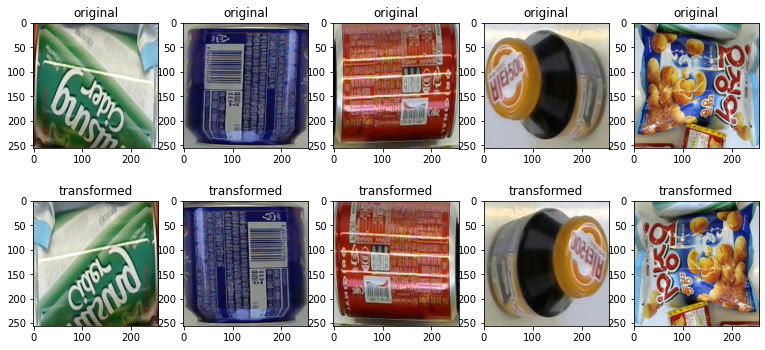

In [195]:
randSample = rand.sample(numList, 5)
horiz_flip = transforms.RandomHorizontalFlip(p=1)
display_augmented_images(horiz_flip)

#### Random Vertical Flip

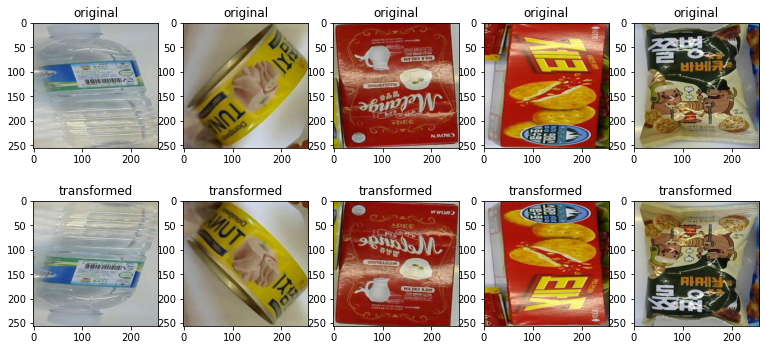

In [196]:
randSample = rand.sample(numList, 5)
vert_flip = transforms.RandomVerticalFlip(p=1)
display_augmented_images(vert_flip)

#### Random Affine

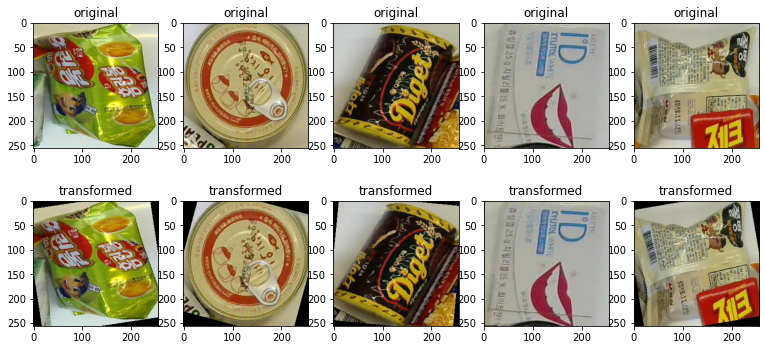

In [197]:
randSample = rand.sample(numList, 5)
affine = transforms.RandomAffine(30)
display_augmented_images(affine)

#### Random Crop

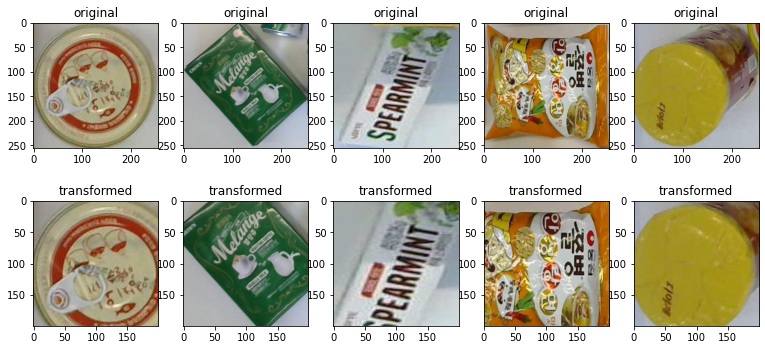

In [198]:
randSample = rand.sample(numList, 5)
crop = transforms.RandomCrop((200, 200))
display_augmented_images(crop)

#### Random Perspective

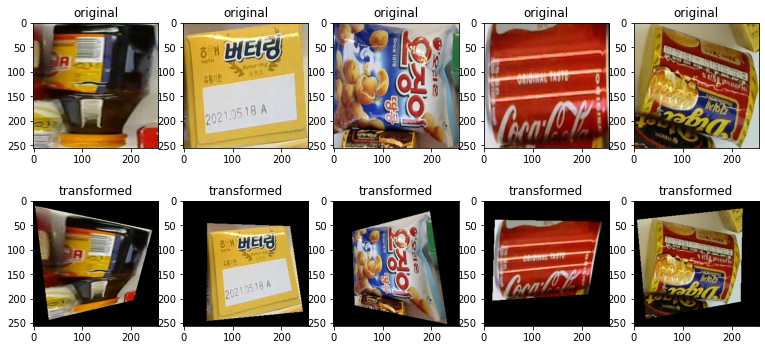

In [199]:
randSample = rand.sample(numList, 5)
perspect = transforms.RandomPerspective(p=1)
display_augmented_images(perspect)

#### Random Rotation

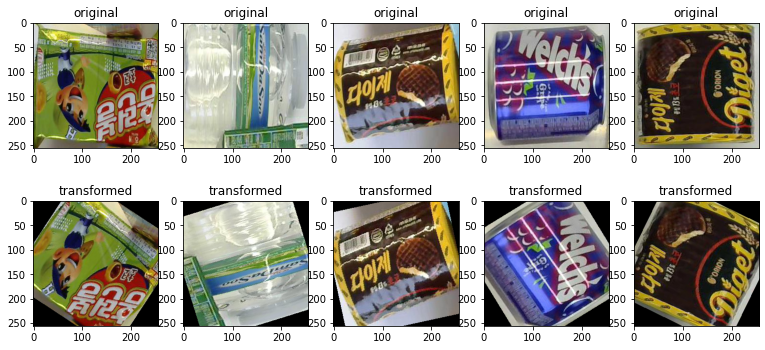

In [200]:
randSample = rand.sample(numList, 5)
rot = transforms.RandomRotation(90)
display_augmented_images(rot)

#### Color Jitter(Brightness)

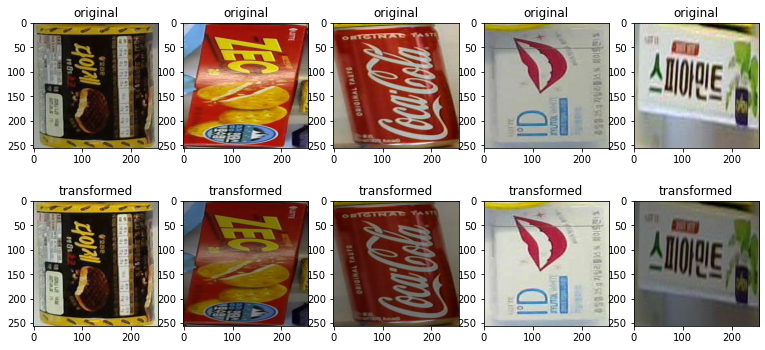

In [210]:
randSample = rand.sample(numList, 5)
color = transforms.ColorJitter(brightness=(0.5, 1.5))
display_augmented_images(color)

#### Color Jitter(Contrast)

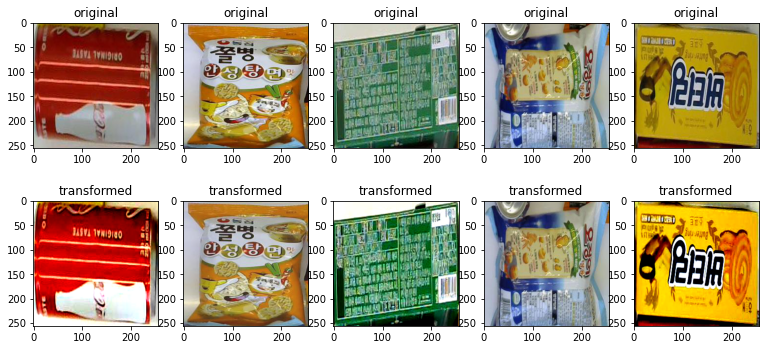

In [214]:
randSample = rand.sample(numList, 5)
color = transforms.ColorJitter(contrast=(0.5, 3))
display_augmented_images(color)

#### Color Jitter(Saturation)

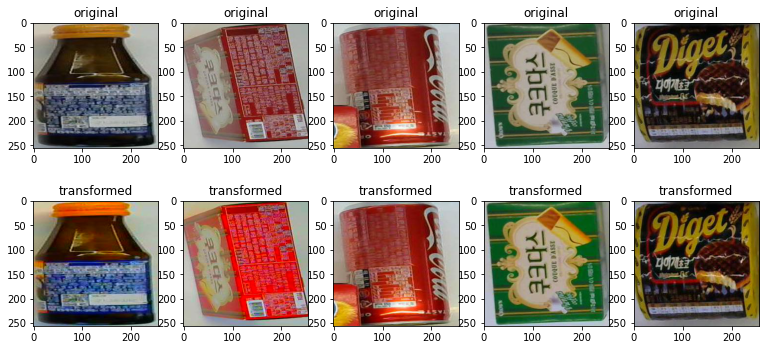

In [218]:
randSample = rand.sample(numList, 5)
color = transforms.ColorJitter(saturation=(0.5, 3))
display_augmented_images(color)

#### Color Jitter(Hue)

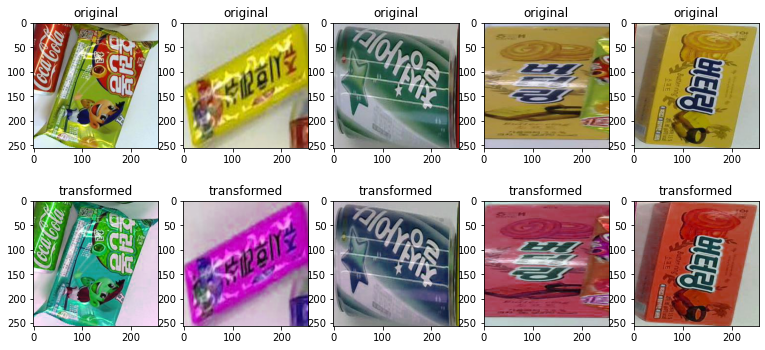

In [219]:
randSample = rand.sample(numList, 5)
color = transforms.ColorJitter(hue=(-0.5, 0.5))
display_augmented_images(color)

#### Pad

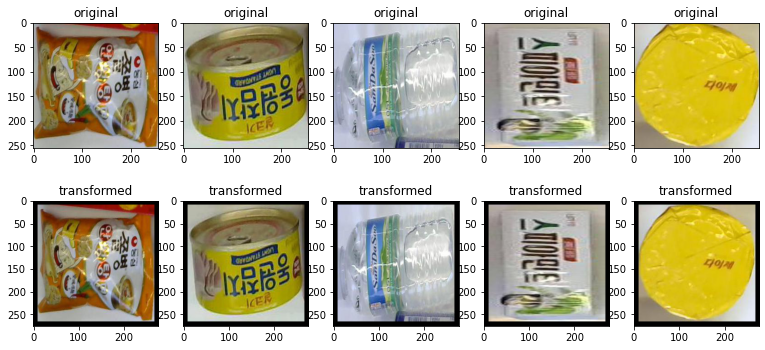

In [220]:
randSample = rand.sample(numList, 5)
pad = transforms.Pad(padding=10)
display_augmented_images(pad)

꽤 쓸만한 augmentation 기법  
- Random Horizontal Flip
- Random Vertical Flip
- Color Jitter(Brightness)
- Color Jitter(Contrast)
- Color Jitter(Saturation)

In [262]:
# 위의 기법들을 확률적으로 선택해서 적용하는 transforms를 만들어보자.
train_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=(0.5, 1.5)),
            transforms.ColorJitter(contrast=(0.5, 3)),
            transforms.ColorJitter(saturation=(0.5, 3)),
        ]),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [263]:
data_dir = "../Data_Set/Labeld_Crop_Data/"
trDsets = {x: dset.ImageFolder(os.path.join(data_dir, x), train_transforms[x]) for x in ['train', 'val']}
trLoaders = {x: torch.utils.data.DataLoader(trDsets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}

teDsets = dset.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)
teLoaders = torch.utils.data.DataLoader(teDsets, batch_size=64, shuffle=False, num_workers=4)

In [264]:
trDsets_sizes = {x: len(trDsets[x]) for x in ['train', 'val']}
class_names = trDsets['train'].classes

### 모델 생성

In [265]:
device3 = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [266]:
model3 = models.resnet18(pretrained=False)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(class_names))
model3 = model3.to(device3)
print(model3)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [267]:
criterion3 = nn.CrossEntropyLoss()
optimizer_ft3 = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler3 = lr_scheduler.ReduceLROnPlateau(optimizer_ft3, factor=0.1, patience=15)

### 모델 훈련

In [268]:
torch.cuda.empty_cache()
model_ft3 = train_model(model3, criterion3, optimizer_ft3, exp_lr_scheduler3, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.2369 Acc: 0.3528
val Loss: 1.3664 Acc: 0.6205
Current learning rate : 0.00100000
Validation loss decreased (inf --> 1.366435).  Saving model ...
Epoch 1/99
----------
train Loss: 1.1043 Acc: 0.6823
val Loss: 0.9170 Acc: 0.7195
Current learning rate : 0.00100000
Validation loss decreased (1.366435 --> 0.917030).  Saving model ...
Epoch 2/99
----------
train Loss: 0.7492 Acc: 0.7832
val Loss: 1.0084 Acc: 0.6376
Current learning rate : 0.00100000
EarlyStopping counter: 1 out of 11
Epoch 3/99
----------
train Loss: 0.5507 Acc: 0.8424
val Loss: 0.4809 Acc: 0.8602
Current learning rate : 0.00100000
Validation loss decreased (0.917030 --> 0.480854).  Saving model ...
Epoch 4/99
----------
train Loss: 0.4366 Acc: 0.8756
val Loss: 1.1653 Acc: 0.7072
Current learning rate : 0.00100000
EarlyStopping counter: 1 out of 11
Epoch 5/99
----------
train Loss: 0.3708 Acc: 0.8902
val Loss: 0.5650 Acc: 0.8058
Current learning rate : 0.00100000
EarlyStopping counter: 2 o

val Loss: 0.0794 Acc: 0.9824
Current learning rate : 0.00100000
EarlyStopping counter: 4 out of 11
Epoch 51/99
----------
train Loss: 0.0566 Acc: 0.9836
val Loss: 0.0804 Acc: 0.9840
Current learning rate : 0.00100000
EarlyStopping counter: 5 out of 11
Epoch 52/99
----------
train Loss: 0.0545 Acc: 0.9833
val Loss: 0.0858 Acc: 0.9836
Current learning rate : 0.00100000
EarlyStopping counter: 6 out of 11
Epoch 53/99
----------
train Loss: 0.0604 Acc: 0.9827
val Loss: 0.0801 Acc: 0.9792
Current learning rate : 0.00100000
EarlyStopping counter: 7 out of 11
Epoch 54/99
----------
train Loss: 0.0416 Acc: 0.9876
val Loss: 0.0644 Acc: 0.9896
Current learning rate : 0.00100000
EarlyStopping counter: 8 out of 11
Epoch 55/99
----------
train Loss: 0.0405 Acc: 0.9874
val Loss: 0.0635 Acc: 0.9884
Current learning rate : 0.00100000
EarlyStopping counter: 9 out of 11
Epoch 56/99
----------
train Loss: 0.0361 Acc: 0.9887
val Loss: 0.0582 Acc: 0.9880
Current learning rate : 0.00100000
Validation loss de

### 모델 테스트

In [269]:
torch.save(model_ft3, 'lotte_model_resnet18_v4.pt')

In [270]:
testModel3 = torch.load('lotte_model_resnet18_v4.pt', map_location=device3)

In [271]:
correct = 0
total = 0
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = testModel3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (100 * correct / total))

Accuracy of test images: 98 %


#### 클래스별 테스트

In [272]:
class_correct = list(0 for i in range(len(class_names)))
class_total = list(0 for i in range(len(class_names)))
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = testModel3(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(c.size(0)):
            label = labels[i]
            class_correct[int(label.item())] += c[i].item()
            class_total[int(label.item())] += 1

for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (tag_dict[int(class_names[i])], 100 * class_correct[i] / class_total[i]))

Accuracy of ID_gum : 99 %
Accuracy of buttering : 100 %
Accuracy of homerunball : 100 %
Accuracy of jjolbyung_noodle : 100 %
Accuracy of juicyfresh : 100 %
Accuracy of jjolbyung_ori : 99 %
Accuracy of spearmint : 97 %
Accuracy of squid_peanut : 100 %
Accuracy of samdasu : 99 %
Accuracy of  tuna : 99 %
Accuracy of toreta : 100 %
Accuracy of vita500 : 100 %
Accuracy of couque_coffee : 98 %
Accuracy of welchs : 100 %
Accuracy of   zec : 98 %
Accuracy of chocopie : 98 %
Accuracy of cidar : 99 %
Accuracy of couque_white : 97 %
Accuracy of  coke : 99 %
Accuracy of diget_ori : 96 %
Accuracy of diget_choco : 94 %
Accuracy of gumi_gumi : 100 %
